# Widzenie komputerowe - Laboratoria nr 5

## Opis laboratoriów



* obraz w dziedzinie częstotliwości,
* analiza obrazu w dziedzinie częstotliwości,
* filtrowanie górno- oraz dolno-przepustowe,
* optymalizacja procesu filtrowania za pomocą operacji splotu korzystając z dziedziny częstotliwości

## Funkcje pomocnicze

Do wykonania zadań niezbędne jest zaimportowanie bibliotek, wykorzystywanych w skrypcie oraz pobranie danych, na których przetwarzane będą operacje.

W skrypcie wykorzystywane będą dwa zestawy danych:
* obraz Lenna (dostępny pod [linkiem](http://www.lenna.org/)) - jeden z najbardziej popularnych obrazów wykorzystywanych historycznie do kompresji i przetwarzania obrazów,
* "Bug Challenge" - zestaw zdjęć mrówki, zrobione z ostrością ustawioną na co raz dalsze fragmenty od obiektywu (dostępny pod [linkiem](http://grail.cs.washington.edu/projects/photomontage/))

In [ ]:
# import niezbędnych bibliotek
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json
import os

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# pobranie niezbędnych bibliotek
!wget -O lena_std.tif http://www.lenna.org/lena_std.tif

--2021-04-01 13:15:24--  http://www.lenna.org/lena_std.tif
Resolving www.lenna.org (www.lenna.org)... 107.180.37.106
Connecting to www.lenna.org (www.lenna.org)|107.180.37.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena_std.tif’

lena_std.tif        100%[===================>] 768.14K  1.20MB/s    in 0.6s    

2021-04-01 13:15:25 (1.20 MB/s) - ‘lena_std.tif’ saved [786572/786572]



Ze względu na problem z wyświetlaniem obrazów przez bibliotekę OpenCV w środowisku Colab, w przypadku korzystania z tej platformy należy skorzystać z funkcji specjalnie do tego przygotowanej.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
      if a.shape[2] == 4:
        a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
      else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

In [ ]:
def h_color(a, interpolation=None, size=None, fy=1.5, fx=1.5, cmap='gray'):
  s = [int(a.shape[0] * fy), int(a.shape[1] * fx)] if size is None else size
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap=cmap, interpolation=interpolation)

In [ ]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td { 
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [ ]:
def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.update_layout(autosize=False, width=500, height=500)
  fig.show()

# Obraz w dziedzinie częstotliwości

Powyższe przykłady przetwarzania obrazów dotyczyły dziedziny intensywności. Inną dziedziną, w której można reprezentować obraz, jest **częstotliwość**. Obraz w dziedzinie częstotliwości należy traktować jako informacje które piksele zawierają jakiś powtarzający się schemat, a które są mało powtarzającymi się wzorami.

Przykładowo, obraz bardzo rozmazany, będzie posiadał rzadko powtarzające się wzorce (a które zajmują rozległy obszar obrazu), natomiast dla obrazu bardzo dokładnego wzorce te będą o wiele częściej się powtarzać i dotyczyć będą wyszczególnionych obszarów obrazu.

Poniżej zaprezentowany został przykład przejścia z dziedziny intensywności do dziedziny częstotliwości.

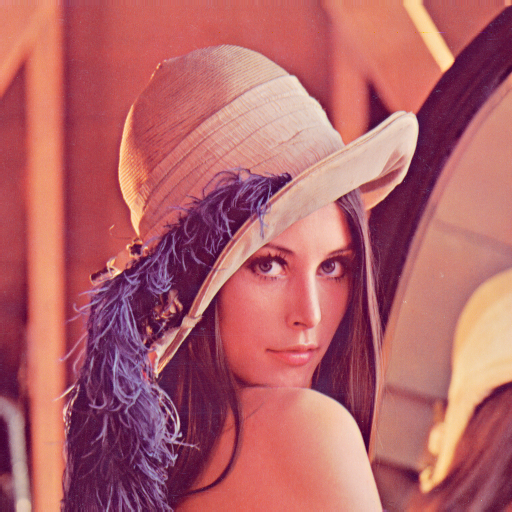

In [ ]:
img = cv2.imread('./lena_std.tif', 1)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(img)

Operację przejścia z dziedziny intensywności do dziedziny częstotliwości można wykonać za pomocą implementacji w OpenCV lub tej dostępnej w bibliotece NumPy. Poniżej zaprezentowany został przykład użycia biblioteki NumPy.

Funkcja **fft2** wykonuje Transformatę Fouriera dla sygnałów 2-wymiarowych. Następnie, korzystając z funkcji **fftshift** przesuwamy dane w ten sposób, aby piksele odpowiadające **niskim częstotliwościom** znajdowały się bliżej środka a piksele **wysokich częstotliwości** na krańcach obrazu (w dziedzinie częstotliwości).



In [ ]:
f = np.fft.fft2(img_grayscale)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))

Otwrotna transformata sprowadza się do wykonania odwrotnego przesunięcie pikseli oraz wykonania operacji **ifft2**, której wynikiem jest obraz w dziedzinie intensywności (w postaci liczby zespolonej, stąd dodatkowe pobranie części rzeczywistej - **real()**).

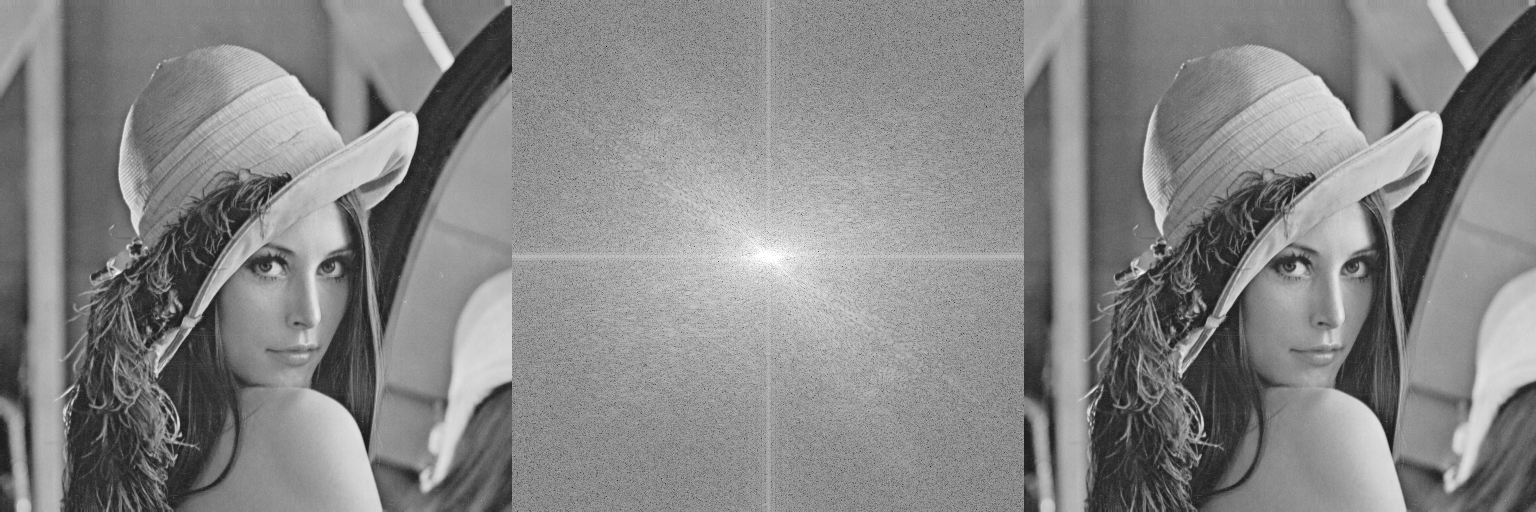

In [ ]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

imshow(np.concatenate([img_grayscale, magnitude_spectrum, img_back], 1))

### Transformata Fouriera

Transformata Fouriera określona jest następującym wzorem:

$${\mathcal{F}}(\omega) = \int_{-\infty}^{\infty} f(x) e^{-2\pi i x \omega} dx$$

Gdzie $\omega$ to częstotliwości omawiane w powyższych przykładach, $f(x)$ obraz w skali intensywności, $i^2 = -1$ - liczba urojona. Powyższy wzór można interpretować następująco:

* ${\mathcal{F}}(\omega)$ wykonywana jest dla każdej częstotliwości (może to być określony z góry przedział lub tak jak w przypadku domyślnej implementacji w numpy częstotliwości z zakresu $<-S_h, S_h>$ oraz $<-S_w, S_w>$, a więc $\omega$ jest dowolną parą utworzoną z tych zakresów),
* dla każdego wywołania ${\mathcal{F}}(\omega)$ wykonywane jest przemnożenie obrazu wejściowego przez składnik podany we wzorze (z odpowiednim $\omega$) i sumowanie otrzymanego elementu. Można to również traktować jako sumę ważoną każdego piksela, gdzie wagą jest podany we wzorze składnik,

## Interpretacja dziedziny częstotliwości

Wiedząc jak wykonać transformatę odwrotną (częstotliwość -> intensywność), możemy wykonać pare eksperymentów, aby przybliżyć zależność pomiędzy wartościami pikseli w dziedzinie częstotliwości a intensywności.

In [ ]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask,(s[0]//2, s[1]//2), s[0]//div, 1, -1)

def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum

def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

Zdefiniujmy obraz (256 x 256) wypełniony samymi zerami z ustawionymi wysokimi wartościami na określonych pozycjach. Pozycjami tymi będą odpowiednio (gdzie $S_h = height / 2 = 128$ oraz $S_w = width / 2 = 128$):

* $(S_h, S_w)$
* $(S_h, S_w - 1)$
* $(S_h, S_w + 1)$
* $(S_h, S_w - 1)$, $(S_h, S_w + 1)$

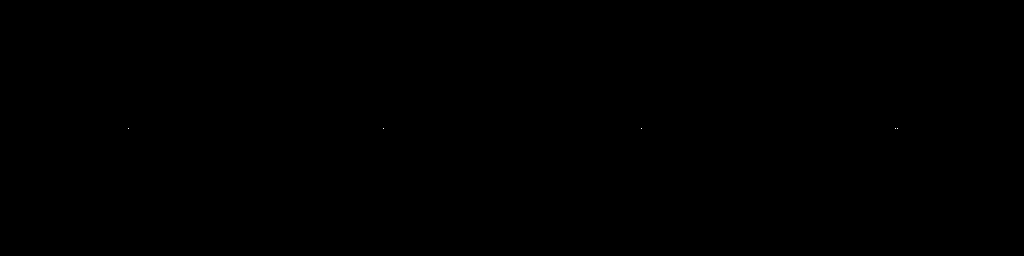

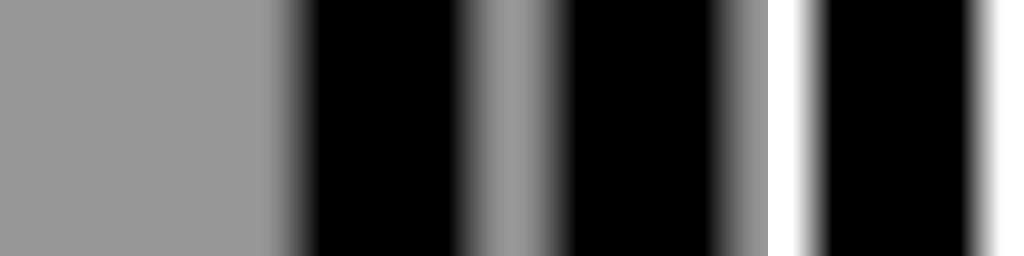

In [ ]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh, sw] = 10000000.0

freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh, sw - 1] = 10000000.0

freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh, sw + 1] = 10000000.0

freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh, sw - 1] = 10000000.0
freq_4[sh, sw + 1] = 10000000.0


img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)

imshow(np.concatenate([freq_1, freq_2, freq_3, freq_4], 1))
imshow(np.concatenate([img_i_1, img_i_2, img_i_3, img_i_4], 1))

Analogicznie dla zmian wartości pikseli wertykalnie:
* $(S_h, S_w)$
* $(S_h - 1, S_w)$
* $(S_h + 1, S_w)$
* $(S_h - 1, S_w)$, $(S_h + 1, S_w)$

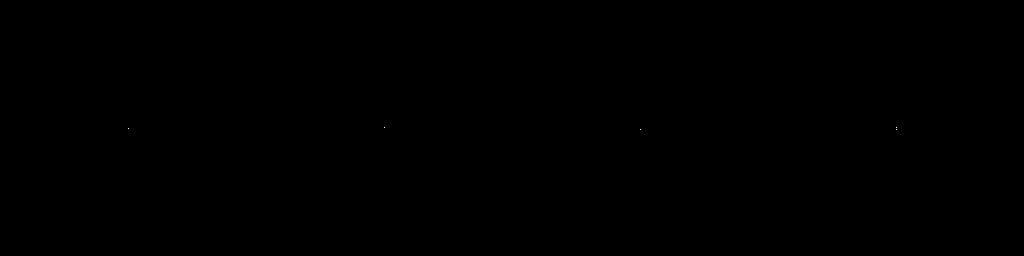

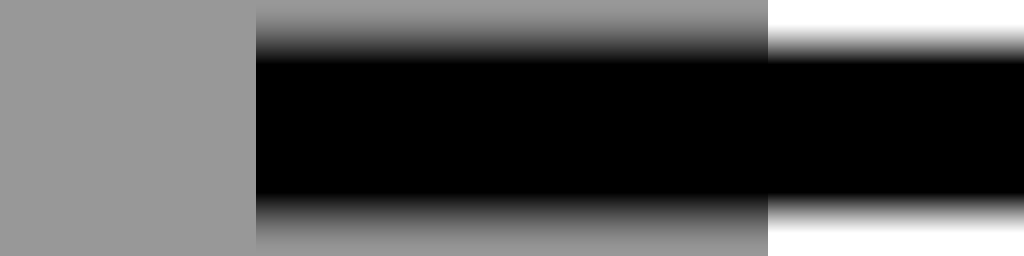

In [ ]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh, sw] = 10000000.0
freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh - 1, sw] = 10000000.0
freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh + 1, sw] = 10000000.0
freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh - 1, sw] = 10000000.0
freq_4[sh + 1, sw] = 10000000.0


img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)

imshow(np.concatenate([freq_1, freq_2, freq_3, freq_4], 1))
imshow(np.concatenate([img_i_1, img_i_2, img_i_3, img_i_4], 1))

Powyższy eksperyment dostarcza następujące wskazówki:
* środkowy piksel odpowiada jednolitemu obrazowi (częstotliwość równa zero),
* piksele odchylone o 1 na lewo i prawo reprezentują te same wyniki, ponieważ odpowiadają im sygnały o przeciwnych częstotliwościach),
* odchylenia horyzontalne odpowiadają horyzontalnym sygnałom 2D na obrazie w dziedzinie intensywności; analogicznie dla wertykalnych odchyleń.



Ustawiając wysokie wartości dalej od środka operacja odwrotnej transformaty fouriera utworzy obrazy w dziedzinie intensywności zawierające sygnały o większej częstotliwości.

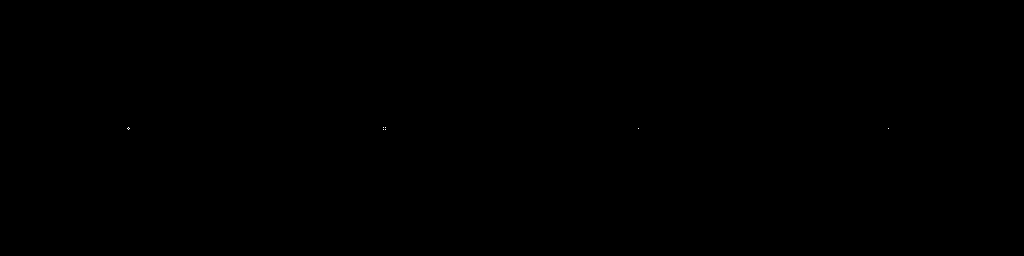

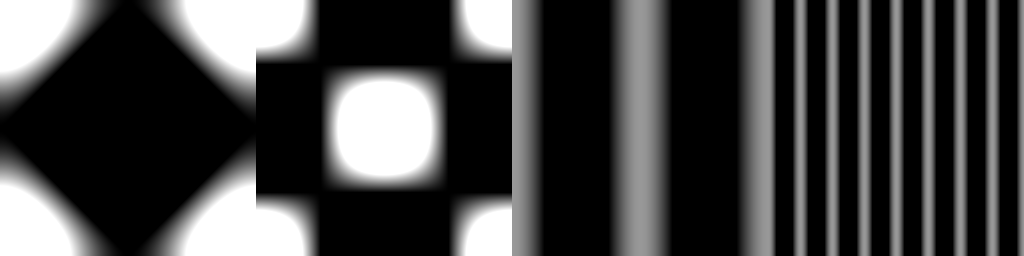

In [ ]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh - 1, sw] = 10000000.0
freq_1[sh + 1, sw] = 10000000.0
freq_1[sh, sw - 1] = 10000000.0
freq_1[sh, sw + 1] = 10000000.0
freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh - 1, sw - 1] = 10000000.0
freq_2[sh + 1, sw + 1] = 10000000.0
freq_2[sh - 1, sw + 1] = 10000000.0
freq_2[sh + 1, sw - 1] = 10000000.0
freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh, sw - 2] = 10000000.0
freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh, sw - 8] = 10000000.0

img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)

imshow(np.concatenate([freq_1, freq_2, freq_3, freq_4], 1))
imshow(np.concatenate([img_i_1, img_i_2, img_i_3, img_i_4], 1))

## Operacje w dziedzinie częstotliwości

Przetwarzanie obrazu w dziedzinie częstotliwości jest ściśle związane z pojęciem konwolucji w dziedzinie intensywności. Zgodnie z twierdzeniem wynikającym z postaci transformaty Fouriera ([link](https://en.wikipedia.org/wiki/Convolution_theorem)) możemy zapisać:

$$(f \ast g)(t) = {\mathcal{F}}^{-1}\{F \cdot G\}$$

gdzie:
* $f$, $F$ - obraz wejściowy odpowiednio w dziedzinie intensywności i częstotliwości,
* $g$, $G$ - kernel/filtr (np. Laplasjan) odpowiednio w dziedzinie intensywności i częstotliwości,
* ${\mathcal{F}^{-1}}$ - odwrotna transformata Fouriera

Powyższa teoria mówi, że operacja konwolucji dwóch funkcji w dziedzinie czasu lub przestrzeni jest równoznaczna z operacją mnożenia **(element-wise)** ich reprezentacji w przestrzeni częstotliwości.


Wcześniejsze transformacje pomiędzy dziedzinami pokazały, że obraz o pewnym rozmiarze (intensywność) będzie miał ten sam rozmiar w dziedzinie częstotliwości. Rozmiar bezpośrednio wpływa liczbę maksymalnych częstotliwości, stąd aby zaprezentować obraz o mniejszym rozmiarze w większej liczbie częstotliwości **można obraz uzupełnić (jak przy konwolucji) samymi zerami**.

Korzystając z implementacji w OpenCV należy zrobić to ręcznie, natomiast przy implementacji NumPy, wystarczy dodać informacje o rozmiarze jako drugi parametr funkcji fft2.

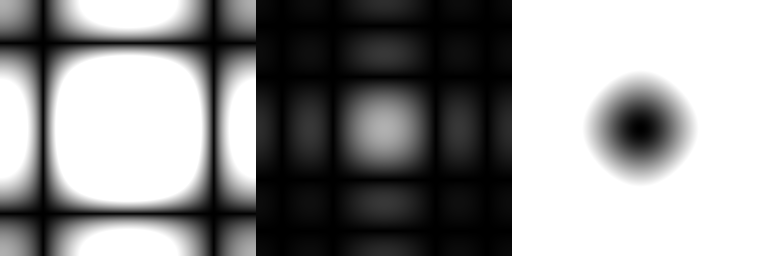

In [ ]:
mean_filter = np.ones((3,3))

x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

laplacian = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])


filters = [mean_filter, gaussian, laplacian]
fft_filters = [np.fft.fft2(x, (256, 256)) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

imshow(np.concatenate(mag_spectrum, 1) * 255)



Posiadając obrazy w tej samej dziedzinie określonej tą samą liczbą częstotliwości, zgodnie z przytoczoną teorią, możemy wykonać odpowiednik operacji konwolucji korzystając z prostego mnożenia w dziedzinie intensywności.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning:

Casting complex values to real discards the imaginary part



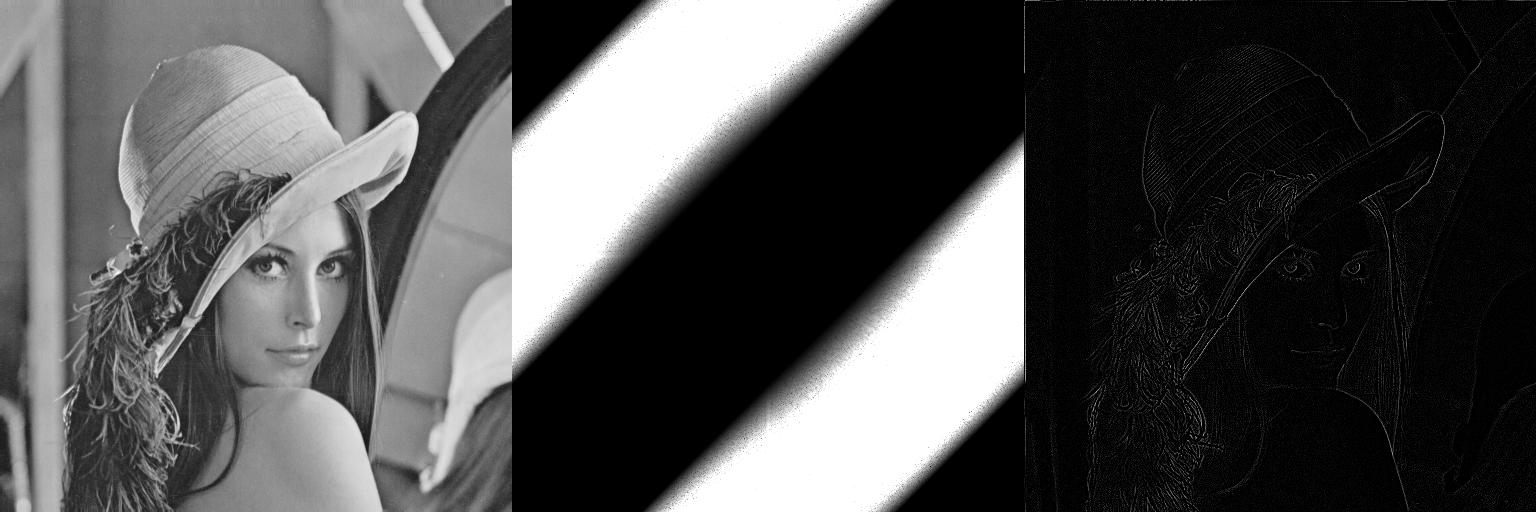

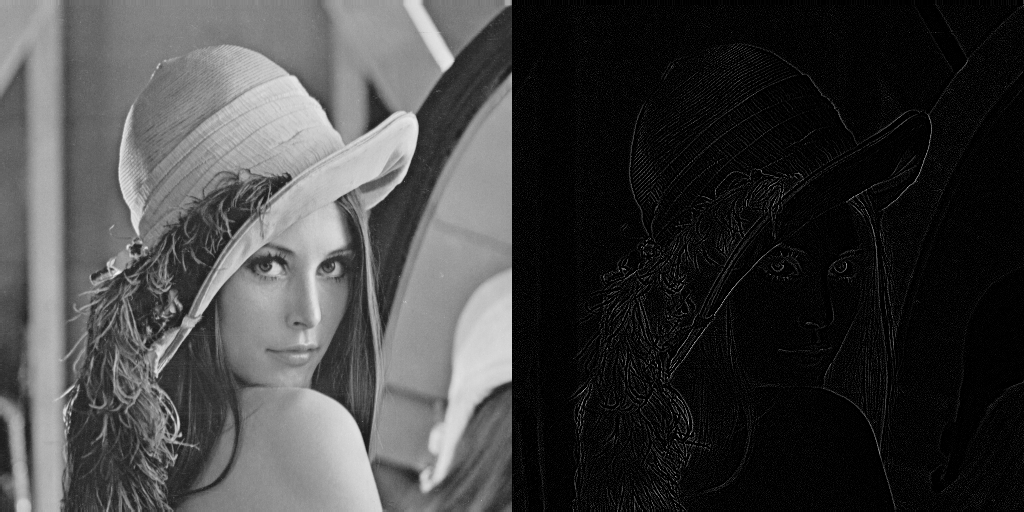

In [ ]:

laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

# intensity
f_lap_shift, f_lap_mag = fft(laplacian, (512, 512))
fshift, spectrum = fft(img_grayscale)
img_i = ifft(fshift * f_lap_shift)

imshow(np.concatenate([img_grayscale, spectrum * f_lap_shift, img_i], 1))

img_i = cv2.filter2D(img_grayscale, -1, laplacian)
imshow(np.concatenate([img_grayscale, img_i], 1))

### Filtr dolnoprzepustowy

Filtrowanie w dziedzinie częstotliwości możemy również podzielić na dolnoprzepustowe i górnoprzepustowe.

Filtrowanie dolnoprzepustowe to takie, które przepuszcza sygnały o małej częstotliwości i ucina sygnały powyżej pewnego progu. Jak wiadomo, sygnały o wysokiej częstotliwości znajdują się na krańcach obrazu, a im bliżej środka, tym sygnały posiadają mniejszą częstotliwość.

Poniżej zostało przedstawione filtrowanie dolnoprzepustowe zrealizowane jako próg odcięcia.

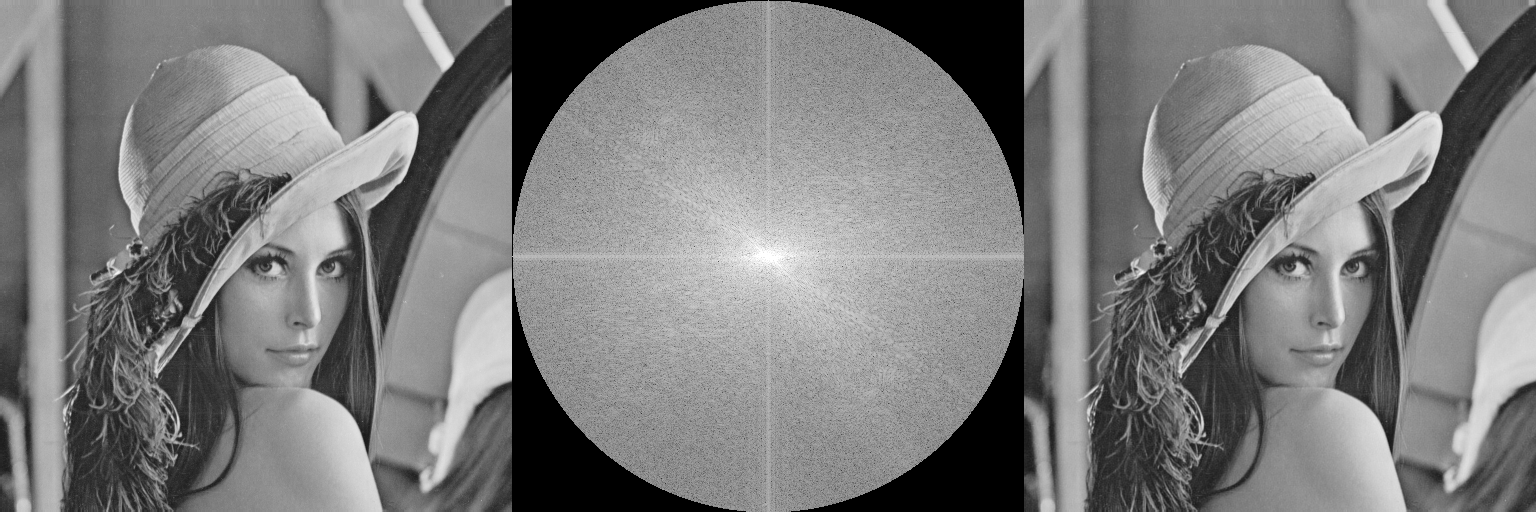

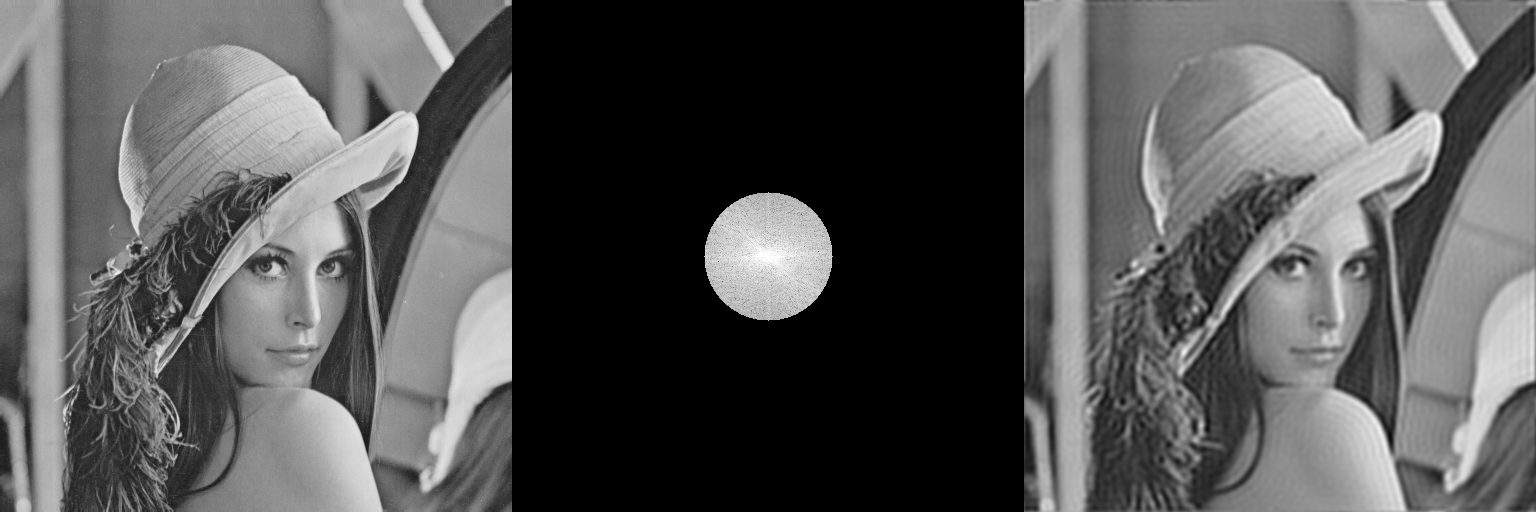

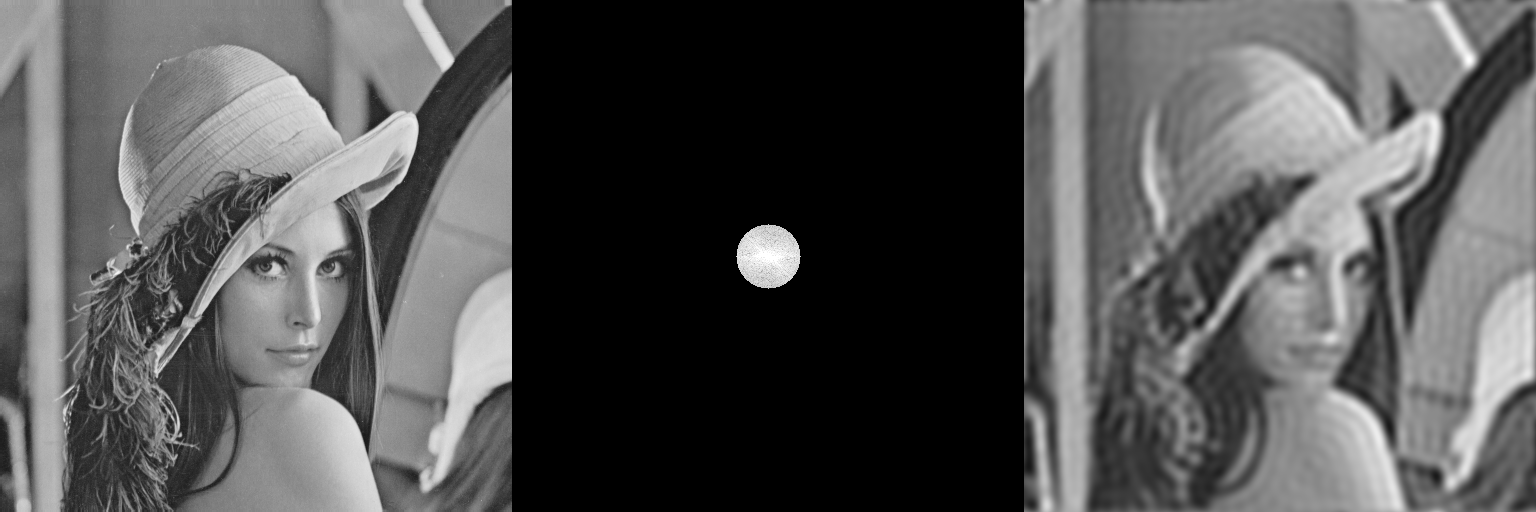

In [ ]:
m1 = get_mask(img_grayscale.shape, 2)
m2 = get_mask(img_grayscale.shape, 8)
m3 = get_mask(img_grayscale.shape, 16)

fshift, spectrum = fft(img_grayscale)

img_back_1 = ifft(fshift * m1)
img_back_2 = ifft(fshift * m2)
img_back_3 = ifft(fshift * m3)

imshow(np.concatenate([img_grayscale, spectrum * m1, img_back_1], 1))
imshow(np.concatenate([img_grayscale, spectrum * m2, img_back_2], 1))
imshow(np.concatenate([img_grayscale, spectrum * m3, img_back_3], 1))

Rezultatem działania filtrów dolnoprzepustowych zazwyczaj powinien być efekt rozmycia ze względu na fakt, że pozbywamy się obszarów o dużej zmienności (jak np. krawędzie, szczególy ale również szum).

**UWAGA: FFT może idealnie sprawdzić się jako kompresja danych.**

### Filtr górnoprzepustowy

Analogicznie działają filtry z rodziny górnoprzepustowych. Przepuszczając sygnały o tylko dużej częstotliwości dokonujemy ekstrakcji miejsc, gdzie są krawędzie, duża ostrość obrazu lub po prostu szum.

Poniżej zaprezentowano filtr górnoprzepustowy zrealizowany jako odcięcie sygnałów poniżej pewnego progu.

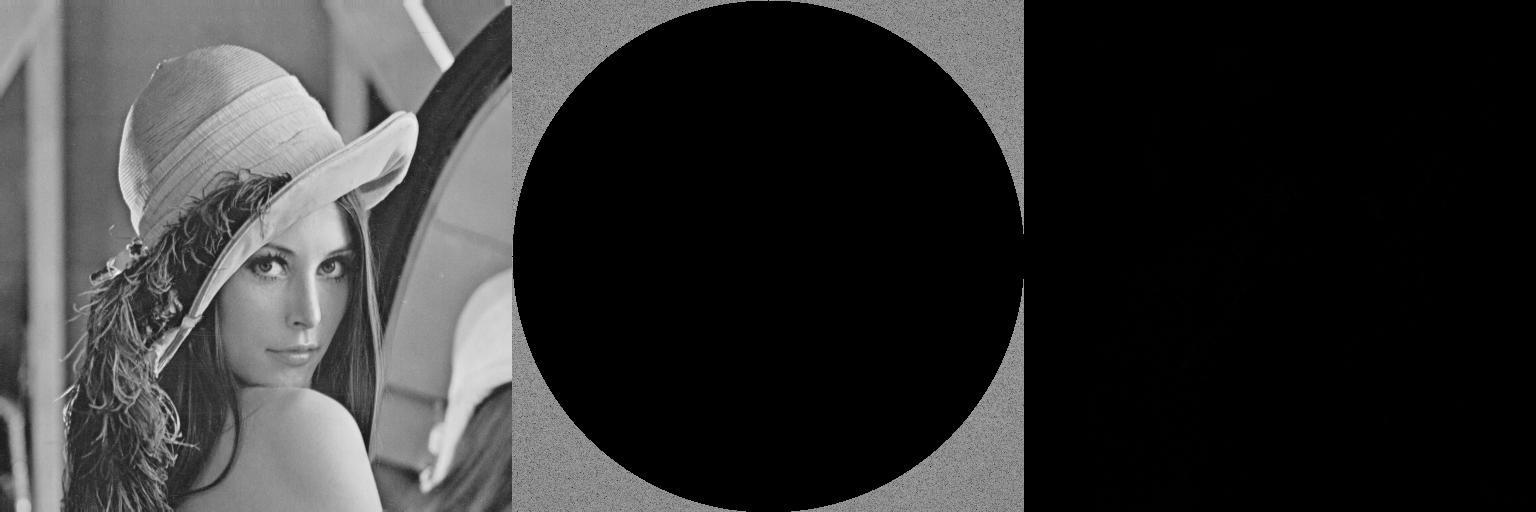

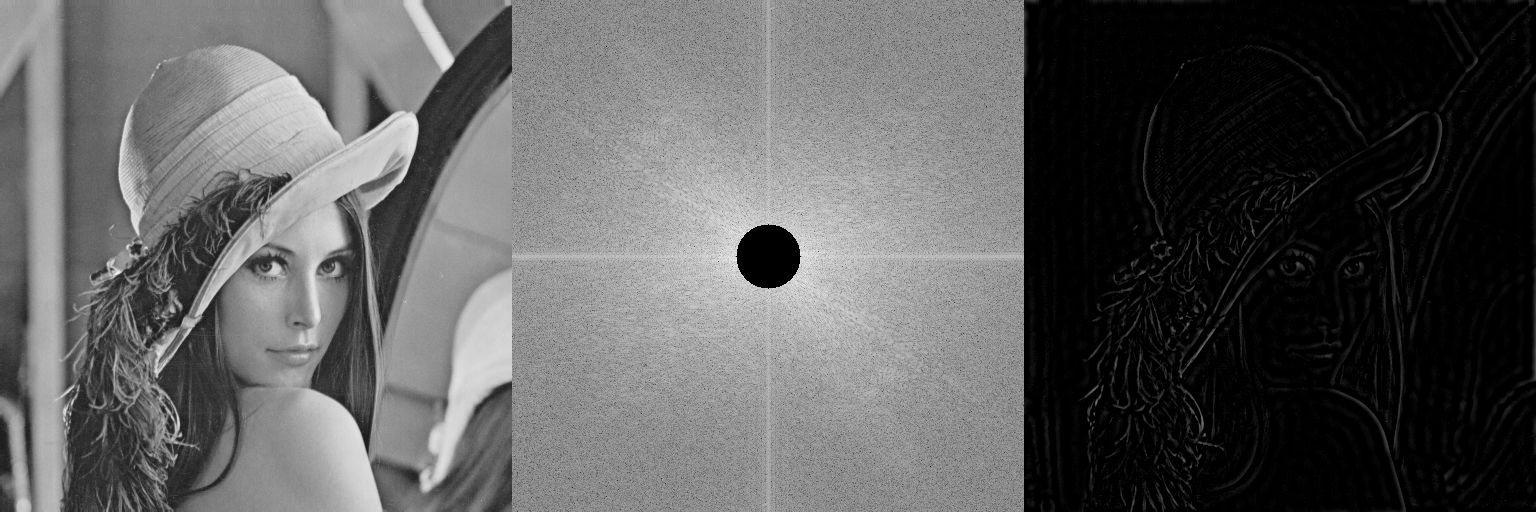

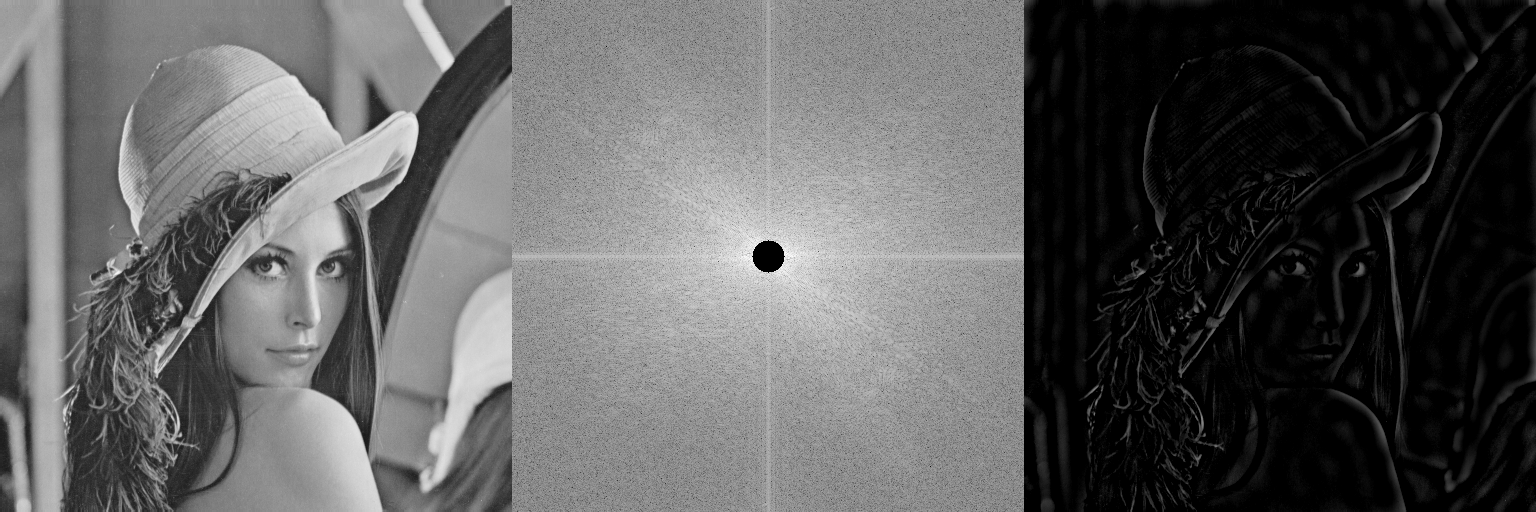

In [ ]:
m1 = 1 - get_mask(img_grayscale.shape, 2)
m2 = 1 - get_mask(img_grayscale.shape, 16)
m3 = 1 - get_mask(img_grayscale.shape, 32)

fshift, spectrum = fft(img_grayscale)

img_back_1 = ifft(fshift * m1)
img_back_2 = ifft(fshift * m2)
img_back_3 = ifft(fshift * m3)

imshow(np.concatenate([img_grayscale, spectrum * m1, img_back_1], 1))
imshow(np.concatenate([img_grayscale, spectrum * m2, img_back_2], 1))
imshow(np.concatenate([img_grayscale, spectrum * m3, img_back_3], 1))

# Zadania

## Zadanie 1

Sprawdź i uargumentuj, który z niżej wypisanych filtrów jest dolnoprzepustowy, a który górnoprzepustowy.

Filtry:
* uśredniający,
* gaussowski,
* sobel,
* laplasjan


In [ ]:
# TODO
raise NotImplementedError()

## Zadanie 2

Wykonaj detekcję krawędzi (osobno pionowo i poziomo) korzystając z filtrów Sobela w dziedzinie częstotliwości, następnie połącz wykryte cechy do jednego obrazu i zaprezentuj wyniki. Działanie w dziedzinie częstotliwości porównaj z działaniem filtru Sobela w dziedzinie intensywności. 

In [ ]:
# TODO
raise NotImplementedError()